In [21]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [22]:
# Función para guardar la tabla Q en un archivo de texto
def save_q_table(q, filename):
    with open(filename, 'w') as f:
        for i in range(q.shape[0]):
            for j in range(q.shape[1]):
                f.write(f"state({i},{j}): {q[i, j, :]}\n")

# Función para guardar las recompensas en un archivo de texto
def save_rewards(rewards, filename):
    with open(filename, 'w') as f:
        for episode, reward in enumerate(rewards):
            f.write(f"Episode {episode}: {reward}\n")

In [26]:
# Función principal para ejecutar el juego
def run(episodes, is_training=True, render=False, epsilon=0.1):
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # Dividir la posición y la velocidad en segmentos
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

    # Inicializar o cargar la Q-table
    if is_training:
        q = np.zeros((len(pos_space), len(vel_space), env.action_space.n))
    else:
        with open('mountain_car.pkl', 'rb') as f:
            q = pickle.load(f)

    learning_rate_a = 0.1
    discount_factor_g = 0.99
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        state = env.reset()[0]
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        terminated = False
        rewards = 0

        while not terminated and rewards > -1000:
            if rng.random() < epsilon:
                action = env.action_space.sample()  # Acción aleatoria (\(\epsilon\)-greedy para exploración)
            else:
                action = np.argmax(q[state_p, state_v, :])  # Acción con mayor valor Q (explotación)

            new_state, reward, terminated, _, _ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            if is_training:
                # Actualización de Q usando la fórmula de acción-valor
                q[state_p, state_v, action] += learning_rate_a * (
                    reward + discount_factor_g * np.max(q[new_state_p, new_state_v, :]) - q[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            rewards += reward

        rewards_per_episode[i] = rewards

    env.close()

    if is_training:
        with open('mountain_car.pkl', 'wb') as f:
            pickle.dump(q, f)
        save_q_table(q, 'q_table.txt')
        save_rewards(rewards_per_episode, 'rewards_per_episode.txt')


        # Graficar las recompensas medias
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(mean_rewards)
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa Media')
    plt.title('Recompensa Media por Episodio')
    plt.grid(True)
    plt.savefig('mountain_car.png')
    plt.show()


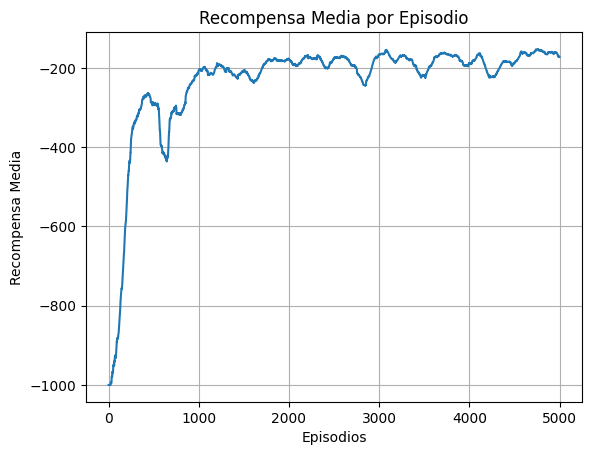

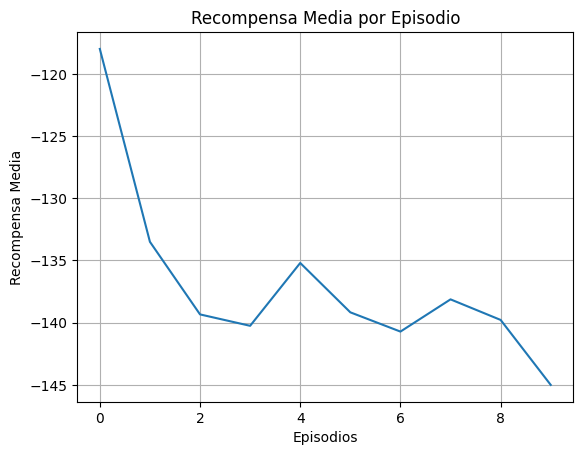

In [28]:
if __name__ == '__main__':
    run(5000, is_training=True, render=False, epsilon=0.1)  # Primero entrena el modelo
    run(10, is_training=False, render=True)  # Luego usa el modelo entrenado
